# Smarter Betas - a regime-switching convex optimized model for factor investing
##### Created by: Izzat Aziz (2021)
##### Modified from: Oprisor, Razvan, and Roy Kwon (2021)

## Theoretical framework
1. Hidden Markov Model (HMM): A memory-less probabilistic model that models a time-series as a Markov chain, or a sequence of discrete, finite states (Ramage 2007).
2. Black Litterman Model (BL): A model that combines Markowitz's mean-variance optimization with Sharpe’s CAPM through a Bayesian approach (Black and Litterman 1992)
3. Convex Optimization: Formulating investment decisions as a convex optimization problem that trades off expected return, risk and transaction costs (Boyd et al. 2017)

## Implementation
1. Generate BL's returns priors (i.e. return views) via HMM (subject to current predicted states, transition matrix, and mean returns given states of assets)
2. Generate BL posterior returns after inputting prior returns and assuming equal-weighted prior
3. Identify the optimized asset allocation for a long-only portfolio by maximizing risk-adjusted returns given BL's posterior returns subject to costs and constraints

In [1]:
# Importing the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import bqplot.pyplot as plt
# import bqviz as bqv
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# Importing Hidden Markov, Black Litterman and Convex Portfolio libraries
from hmmlearn.hmm import GaussianHMM as ghmm
from pypfopt import black_litterman, risk_models, efficient_frontier
import cvxportfolio as cp

# Ignoring warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Importing Bloomberg Query library
# import bql
# bq = bql.Service()

### All required user inputs needed for the model

In [3]:
# ## Ticker and dates inputs (FOR BQUANT ONLY)
# # Input ETF, macro and benchmark tickers
# tickers = ['M1WOMOM Index','M1WOQU Index','M1WOSC Index','M1WOEV Index','M1WOMVOL Index']
# macro_tickers= ['NOWCYQCP Index','USYC2Y10 Index','USGGBE05 Index']
# benchmark = ['MXWO Index']
# # Set dates
# start_date ='2002-01-01'
# end_date = '2021-01-01'


## HMM inputs
# User input sliding window (i.e. hHw many periods of training data to use for the model)
T = 520
# User input hidden states in HMM (i.e. How many states are there for the model)
states = 2
# Toggle adding macro indicators into the model
macro = True

## BL inputs
# The weight on view scalar - a sensible default is 0.05
tau = 0.05
# The risk aversion parameter - a sensible default is 1 but depends on fund's risk profile. 
risk_aversion = 1
# Assuming risk free rate is 1% p.a.
rf=0.01
# confidence of priors (1-uncertainty)
confidences = 0.975
# covariance window
TCov = 260

## Convex Optimizer inputs
# Transaction costs per trade in bps
t_cost = 5

# Main risk hyperparameters for the convex optimizer - depends on fund's risk profile and requires fine-tuning
gamma_risk = 1.5
gamma_trade = 1.75
StartPred = "2015-01-09"

### Reading datafile - (If using BQuant, run the next cell instead)

In [4]:
# Read bloomberg data
df_price = pd.read_excel(io="data.xlsx",sheet_name="price", index_col=0)
df_vol = pd.read_excel(io="data.xlsx",sheet_name="vol", index_col=0)
df_macro = pd.read_excel(io="data.xlsx",sheet_name="macro", index_col=0)
df_mktcap = pd.read_excel(io="data.xlsx",sheet_name="market_cap", index_col=0).dropna()
df_benchmark = pd.read_excel(io="data.xlsx",sheet_name="benchmark", index_col=0).dropna()

# Converting absolute returns and abslute volatility to percentage change period-on-period
df_pct_ret = df_price.pct_change().dropna()
df_pct_vol = df_vol.pct_change().dropna()

# Creating a covariance matrix for Black Litterman 
cov_matrix = df_pct_ret.rolling(window=T, min_periods=T, closed='neither').cov().dropna()

### Generate data via BQuant (uncomment to use it)

In [4]:
# # Creating a dataframe for ticker prices
# price = bq.func.rolling(bq.data.px_last(dates=bq.func.range('0d','0d'),fill='prev'),iterationdates=bq.func.range(start=start_date, end=end_date, frq='W'))
# price = bql.Request(tickers, {'Price': price})
# price = bq.execute(price)
# df_price = price[0].df()
# df_price = df_price.reset_index().pivot(index='DATE', columns='ID', values='Price')
# df_price.index.name = 'dates'

# # Creating a dataframe for ticker 10 day volatility
# vol = bq.func.rolling(bq.data.volatility(calc_interval='10d'),iterationdates=bq.func.range(start=start_date, end=end_date, frq='W' ))
# vol = bql.Request(tickers, {'Vol': vol})
# vol = bq.execute(vol)
# df_vol = vol[0].df()
# df_vol = df_vol.reset_index().pivot(index='DATE', columns='ID', values='Vol')
# df_vol.index.name = 'dates'

# # Creating a dataframe for ticker market caps
# mcaps = bq.func.rolling(bq.data.cur_mkt_cap(dates=bq.func.range('0d','0d'),fill='prev'),iterationdates=bq.func.range(start=start_date, end=end_date, frq='W'))
# mcaps = bql.Request(tickers, {'Market cap': mcaps})
# mcaps = bq.execute(mcaps)
# df_mktcap = mcaps[0].df()
# df_mktcap = df_mktcap.reset_index().pivot(index='DATE', columns='ID', values='Market cap').dropna()
# df_mktcap.index.name = 'dates'
# df_mktcap = df_mktcap.dropna()

# # Creating a dataframe for macro indicators
# macro = bq.func.rolling(bq.data.px_last(dates=bq.func.range('0d','0d'),fill='prev'),iterationdates=bq.func.range(start=start_date, end=end_date, frq='W'))
# macro = bql.Request(macro_tickers, {'Macro': macro})
# macro = bq.execute(macro)
# df_macro = macro[0].df()
# df_macro = df_macro.reset_index().pivot(index='DATE', columns='ID', values='Macro')
# df_macro.index.name = 'dates'
# df_macro = df_macro.dropna()

# # Creating a dataframe for benchmark price
# bench_price = bq.func.rolling(bq.data.px_last(dates=bq.func.range('0d','0d'),fill='prev'),iterationdates=bq.func.range(start=start_date, end=end_date, frq='W'))
# bench_price = bql.Request(benchmark, {'Price': bench_price})
# bench_price = bq.execute(bench_price)
# df_benchmark = bench_price[0].df()
# df_benchmark = df_benchmark.reset_index().pivot(index='DATE', columns='ID', values='Price')
# df_benchmark.index.name = 'dates'
# df_benchmark = df_benchmark.dropna()

# # Converting absolute returns and abslute volatility to percentage change period-on-period
# df_pct_ret = df_price.pct_change().dropna()
# df_pct_vol = df_vol.pct_change().dropna()

# # Creating a covariance matrix for Black Litterman 
# cov_matrix = df_pct_ret.rolling(window=T, min_periods=T, closed='neither').cov().dropna()

### Creating the necessary functions for later use in the model

In [5]:
# Modified from Falkner (2017):"Stock-Forecasting using HMM - A Model Averaging Approach" (https://github.com/Mojomotte/ML2-Stock-Forecasting-using-HMM---An-Model-Averaging-Approach)
# First implemented by Nguyen (2016): "Stock Price Prediction using Hidden Markov Model" (https://editorialexpress.com/cgi-bin/conference/download.cgi?db_name=SILC2016&paper_id=38)

# Creating an HMM training and predicting function to be used later on
def hmm_model(data, states, max_iterations=1000, conv=True, show=True):
    
    if show == True:
        print('Fitting and predicting... ', end='')
    
    # Creating a basic Hidden Markov Model
    model = ghmm(n_components = states,
                 covariance_type='full',
                 n_iter = max_iterations)
    
    # Fitting model to data
    model.fit(data)
    state_prob = model.predict_proba(data)
    pred_states = model.predict(data)
   
    if show == True:
        print('done')    
    
        # Print if model converged
        if conv == True:
            print('Converged: {}'.format(model.monitor_.converged))
    
    # Calculating predicted returns GIVEN current state
    # Transition matrix given the current state dot multiplied my the expected returns given state matrix
    pred_ret = np.dot(model.transmat_[pred_states[-1],:],model.means_)
    
    # Extracting current predicted state as calculated by the model
    pred_states = pred_states[-1]
    
    # Returning predicted return and predict states
    return(pred_ret,pred_states)

# Creating a function to convert predicted returns (% growth period-on-period) into predicted values
def pred_val(dprice,dpct):
    df = dprice
    name = df.columns[0]
    df.rename(columns ={df.columns[0]:'{} - actual'.format(name)},inplace = True)
    length = len(dpct.index)
    df = df.iloc[-length:]
    df = df.append(pd.DataFrame(index =(df.iloc[[-1]].index +pd.Timedelta(days=7))))
    df['{}'.format(name)] = dpct
    df['{}'.format(name)] = df['{} - actual'.format(name)] * (1+df['{}'.format(name)])
    df['{}'.format(name)] = df['{}'.format(name)].shift(1)
    df.drop('{} - actual'.format(name), axis=1, inplace=True)
    df = df.dropna()
    
    return(df)

### Generating HMM prediction (i.e. BL's priors returns)

In [6]:
# Creating an empty dataframe to store predicted returns (priors for the Black Litterman Model)
prior_ret = pd.DataFrame(index=df_pct_ret.dropna().index, columns = df_price.columns)
prior_ret = prior_ret.iloc[T-1:]

# Creating an empty dataframe to store predicted states
df_pred_states = pd.DataFrame(index=df_pct_ret.dropna().index, columns = df_price.columns)
df_pred_states = df_pred_states.iloc[T-1:]

# Creating empty arrays for each Ticker to store their respective predicted returns (i.e. prior returns for Black Litterman)
d = {name: pd.DataFrame(index=[df_pct_ret.dropna()],columns = df_price.columns) for name in df_price.columns}

# Main calculation loop - For each ticker, train the model given user inputs (i.e. sliding window, states, macro, data) and predict returns
for name in df_price.columns:
    time_walk = 0
    
    if macro == True:
        d[name] = pd.concat([df_pct_ret.loc[:,['{}'.format(name)]],df_pct_vol.loc[:,['{}'.format(name)]],df_macro], axis=1).dropna()

    else:
         d[name] = pd.concat([df_pct_ret.loc[:,['{}'.format(name)]],df_pct_vol.loc[:,['{}'.format(name)]]], axis=1).dropna()    

    for q in range(0,len(prior_ret.index)):

        print()
        print('{}: LOOP {} / {}'.format(name, (q+1),len(prior_ret.index)))

        pred_ret,pred_states = hmm_model(data=d[name].iloc[time_walk:time_walk+T],states=states)

        prior_ret[name].iloc[q:q+1] = pred_ret[0:1]
        df_pred_states[name].iloc[q:1+1] = pred_states

        time_walk +=1
    
print("Finished")   


mom: LOOP 1 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 2 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 3 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 4 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 5 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 6 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 7 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 8 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 9 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 10 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 11 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 12 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 13 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 14 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 15 / 429
Fitting and predicting... done
Converged: True

mom


mom: LOOP 124 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 125 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 126 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 127 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 128 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 129 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 130 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 131 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 132 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 133 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 134 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 135 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 136 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 137 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 138 / 429
Fitting and predicting... d

Fitting and predicting... done
Converged: True

mom: LOOP 247 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 248 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 249 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 250 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 251 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 252 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 253 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 254 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 255 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 256 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 257 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 258 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 259 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 260 / 429
Fitting and predicting... done
Converged: True



mom: LOOP 368 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 369 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 370 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 371 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 372 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 373 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 374 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 375 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 376 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 377 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 378 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 379 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 380 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 381 / 429
Fitting and predicting... done
Converged: True

mom: LOOP 382 / 429
Fitting and predicting... do

Fitting and predicting... done
Converged: True

qual: LOOP 62 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 63 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 64 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 65 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 66 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 67 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 68 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 69 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 70 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 71 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 72 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 73 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 74 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 75 / 429
Fitting and predicting... done
Converged: True



Converged: True

qual: LOOP 184 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 185 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 186 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 187 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 188 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 189 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 190 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 191 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 192 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 193 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 194 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 195 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 196 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 197 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 198 / 

Fitting and predicting... done
Converged: True

qual: LOOP 306 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 307 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 308 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 309 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 310 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 311 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 312 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 313 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 314 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 315 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 316 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 317 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 318 / 429
Fitting and predicting... done
Converged: True

qual: LOOP 319 / 429
Fitting and predicting... done
Con

Fitting and predicting... done
Converged: True

qual: LOOP 429 / 429
Fitting and predicting... done
Converged: True

small: LOOP 1 / 429
Fitting and predicting... done
Converged: True

small: LOOP 2 / 429
Fitting and predicting... done
Converged: True

small: LOOP 3 / 429
Fitting and predicting... done
Converged: True

small: LOOP 4 / 429
Fitting and predicting... done
Converged: True

small: LOOP 5 / 429
Fitting and predicting... done
Converged: True

small: LOOP 6 / 429
Fitting and predicting... done
Converged: True

small: LOOP 7 / 429
Fitting and predicting... done
Converged: True

small: LOOP 8 / 429
Fitting and predicting... done
Converged: True

small: LOOP 9 / 429
Fitting and predicting... done
Converged: True

small: LOOP 10 / 429
Fitting and predicting... done
Converged: True

small: LOOP 11 / 429
Fitting and predicting... done
Converged: True

small: LOOP 12 / 429
Fitting and predicting... done
Converged: True

small: LOOP 13 / 429
Fitting and predicting... done
Converged: T

Converged: True

small: LOOP 119 / 429
Fitting and predicting... done
Converged: True

small: LOOP 120 / 429
Fitting and predicting... done
Converged: True

small: LOOP 121 / 429
Fitting and predicting... done
Converged: True

small: LOOP 122 / 429
Fitting and predicting... done
Converged: True

small: LOOP 123 / 429
Fitting and predicting... done
Converged: True

small: LOOP 124 / 429
Fitting and predicting... done
Converged: True

small: LOOP 125 / 429
Fitting and predicting... done
Converged: True

small: LOOP 126 / 429
Fitting and predicting... done
Converged: True

small: LOOP 127 / 429
Fitting and predicting... done
Converged: True

small: LOOP 128 / 429
Fitting and predicting... done
Converged: True

small: LOOP 129 / 429
Fitting and predicting... done
Converged: True

small: LOOP 130 / 429
Fitting and predicting... done
Converged: True

small: LOOP 131 / 429
Fitting and predicting... done
Converged: True

small: LOOP 132 / 429
Fitting and predicting... done
Converged: True

sma


small: LOOP 236 / 429
Fitting and predicting... done
Converged: True

small: LOOP 237 / 429
Fitting and predicting... done
Converged: True

small: LOOP 238 / 429
Fitting and predicting... done
Converged: True

small: LOOP 239 / 429
Fitting and predicting... done
Converged: True

small: LOOP 240 / 429
Fitting and predicting... done
Converged: True

small: LOOP 241 / 429
Fitting and predicting... done
Converged: True

small: LOOP 242 / 429
Fitting and predicting... done
Converged: True

small: LOOP 243 / 429
Fitting and predicting... done
Converged: True

small: LOOP 244 / 429
Fitting and predicting... done
Converged: True

small: LOOP 245 / 429
Fitting and predicting... done
Converged: True

small: LOOP 246 / 429
Fitting and predicting... done
Converged: True

small: LOOP 247 / 429
Fitting and predicting... done
Converged: True

small: LOOP 248 / 429
Fitting and predicting... done
Converged: True

small: LOOP 249 / 429
Fitting and predicting... done
Converged: True

small: LOOP 250 / 4

Fitting and predicting... done
Converged: True

small: LOOP 358 / 429
Fitting and predicting... done
Converged: True

small: LOOP 359 / 429
Fitting and predicting... done
Converged: True

small: LOOP 360 / 429
Fitting and predicting... done
Converged: True

small: LOOP 361 / 429
Fitting and predicting... done
Converged: True

small: LOOP 362 / 429
Fitting and predicting... done
Converged: True

small: LOOP 363 / 429
Fitting and predicting... done
Converged: True

small: LOOP 364 / 429
Fitting and predicting... done
Converged: True

small: LOOP 365 / 429
Fitting and predicting... done
Converged: True

small: LOOP 366 / 429
Fitting and predicting... done
Converged: True

small: LOOP 367 / 429
Fitting and predicting... done
Converged: True

small: LOOP 368 / 429
Fitting and predicting... done
Converged: True

small: LOOP 369 / 429
Fitting and predicting... done
Converged: True

small: LOOP 370 / 429
Fitting and predicting... done
Converged: True

small: LOOP 371 / 429
Fitting and predicti

Fitting and predicting... done
Converged: True

val: LOOP 52 / 429
Fitting and predicting... done
Converged: True

val: LOOP 53 / 429
Fitting and predicting... done
Converged: True

val: LOOP 54 / 429
Fitting and predicting... done
Converged: True

val: LOOP 55 / 429
Fitting and predicting... done
Converged: True

val: LOOP 56 / 429
Fitting and predicting... done
Converged: True

val: LOOP 57 / 429
Fitting and predicting... done
Converged: True

val: LOOP 58 / 429
Fitting and predicting... done
Converged: True

val: LOOP 59 / 429
Fitting and predicting... done
Converged: True

val: LOOP 60 / 429
Fitting and predicting... done
Converged: True

val: LOOP 61 / 429
Fitting and predicting... done
Converged: True

val: LOOP 62 / 429
Fitting and predicting... done
Converged: True

val: LOOP 63 / 429
Fitting and predicting... done
Converged: True

val: LOOP 64 / 429
Fitting and predicting... done
Converged: True

val: LOOP 65 / 429
Fitting and predicting... done
Converged: True

val: LOOP 66 /

Fitting and predicting... done
Converged: True

val: LOOP 175 / 429
Fitting and predicting... done
Converged: True

val: LOOP 176 / 429
Fitting and predicting... done
Converged: True

val: LOOP 177 / 429
Fitting and predicting... done
Converged: True

val: LOOP 178 / 429
Fitting and predicting... done
Converged: True

val: LOOP 179 / 429
Fitting and predicting... done
Converged: True

val: LOOP 180 / 429
Fitting and predicting... done
Converged: True

val: LOOP 181 / 429
Fitting and predicting... done
Converged: True

val: LOOP 182 / 429
Fitting and predicting... done
Converged: True

val: LOOP 183 / 429
Fitting and predicting... done
Converged: True

val: LOOP 184 / 429
Fitting and predicting... done
Converged: True

val: LOOP 185 / 429
Fitting and predicting... done
Converged: True

val: LOOP 186 / 429
Fitting and predicting... done
Converged: True

val: LOOP 187 / 429
Fitting and predicting... done
Converged: True

val: LOOP 188 / 429
Fitting and predicting... done
Converged: True



Fitting and predicting... done
Converged: True

val: LOOP 300 / 429
Fitting and predicting... done
Converged: True

val: LOOP 301 / 429
Fitting and predicting... done
Converged: True

val: LOOP 302 / 429
Fitting and predicting... done
Converged: True

val: LOOP 303 / 429
Fitting and predicting... done
Converged: True

val: LOOP 304 / 429
Fitting and predicting... done
Converged: True

val: LOOP 305 / 429
Fitting and predicting... done
Converged: True

val: LOOP 306 / 429
Fitting and predicting... done
Converged: True

val: LOOP 307 / 429
Fitting and predicting... done
Converged: True

val: LOOP 308 / 429
Fitting and predicting... done
Converged: True

val: LOOP 309 / 429
Fitting and predicting... done
Converged: True

val: LOOP 310 / 429
Fitting and predicting... done
Converged: True

val: LOOP 311 / 429
Fitting and predicting... done
Converged: True

val: LOOP 312 / 429
Fitting and predicting... done
Converged: True

val: LOOP 313 / 429
Fitting and predicting... done
Converged: True



Fitting and predicting... done
Converged: True

val: LOOP 425 / 429
Fitting and predicting... done
Converged: True

val: LOOP 426 / 429
Fitting and predicting... done
Converged: True

val: LOOP 427 / 429
Fitting and predicting... done
Converged: True

val: LOOP 428 / 429
Fitting and predicting... done
Converged: True

val: LOOP 429 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 1 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 2 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 3 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 4 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 5 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 6 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 7 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 8 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 9 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 10 / 429

Fitting and predicting... done
Converged: True

vol: LOOP 119 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 120 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 121 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 122 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 123 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 124 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 125 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 126 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 127 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 128 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 129 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 130 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 131 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 132 / 429
Fitting and predicting... done
Converged: True



Converged: True

vol: LOOP 241 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 242 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 243 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 244 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 245 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 246 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 247 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 248 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 249 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 250 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 251 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 252 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 253 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 254 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 255 / 429
Fitting and

Fitting and predicting... done
Converged: True

vol: LOOP 363 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 364 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 365 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 366 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 367 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 368 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 369 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 370 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 371 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 372 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 373 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 374 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 375 / 429
Fitting and predicting... done
Converged: True

vol: LOOP 376 / 429
Fitting and predicting... done
Converged: True



### Converting HMM returns into values

In [7]:
# Creating an HMM predicted value array
HMM_pred_val = prior_ret.copy()
HMM_pred_val.drop(HMM_pred_val.columns, axis=1, inplace=True)
for q in range(0,len(prior_ret.columns)):
    new_pred_val = pred_val(df_price.iloc[:,q:q+1], prior_ret.iloc[:,q:q+1])
    HMM_pred_val = pd.concat([HMM_pred_val,new_pred_val], axis =1).dropna()

### Generating BL's posterior returns

In [8]:
K = min(len(prior_ret),len(df_mktcap))
N = len(prior_ret.columns)
BL_mcaps = df_mktcap.iloc[-K:]
BL_prior = prior_ret.iloc[-K:]
BL_cov_matrix = cov_matrix.iloc[-N*K:,:]
view_confidences = pd.Series(confidences, index =[df_price]) 
L = len(df_pct_ret)-K

# Creating an empty data frame to store Black Litterman posterior returns
posterior_ret = pd.DataFrame(index=df_pct_ret.dropna().index, columns = df_price.columns)
posterior_ret = posterior_ret.iloc[-K:]

# # Main Black Litterman loop to generate posterior returns given prior returns and assuming equally-weighted priors
# for Q in range(0,K):
#     cov_steps = Q * N
#     cov_steps_t = cov_steps + N
#     bl = black_litterman.BlackLittermanModel(BL_cov_matrix.iloc[cov_steps:cov_steps_t], pi="market", absolute_views=pd.Series(BL_prior.iloc[Q]), market_caps = BL_mcaps.iloc[Q], omega="idzorek",view_confidences=view_confidences, tau=tau, risk_aversion = risk_aversion, risk_free_rate = rf)
#     posterior_ret.iloc[Q] = bl.bl_returns()
    
# uncomment to use ledoit wolf shrinkage covariance    
for Q in range(0,K):
    BL_cov_matrix = risk_models.CovarianceShrinkage(df_pct_ret.iloc[(L+Q+1-T):(L+Q+1)],returns_data=True,frequency=1).ledoit_wolf()
    bl = black_litterman.BlackLittermanModel(BL_cov_matrix, pi="market", absolute_views=pd.Series(BL_prior.iloc[Q]),omega="idzorek",view_confidences=view_confidences, market_caps = BL_mcaps.iloc[Q], tau=tau, risk_aversion = risk_aversion, risk_free_rate = rf)
    posterior_ret.iloc[Q] = bl.bl_returns()

### Converting BL's returns into values

In [9]:
# Creating a BL predicted value array
BL_pred_val = posterior_ret.copy()
BL_pred_val.drop(BL_pred_val.columns, axis=1, inplace=True)
for q in range(0,len(posterior_ret.columns)):
    new_pred_val = pred_val(df_price.iloc[:,q:q+1], posterior_ret.iloc[:,q:q+1])
    BL_pred_val = pd.concat([BL_pred_val,new_pred_val], axis =1).dropna()

### Plotting predicted returns from HMM and BL model

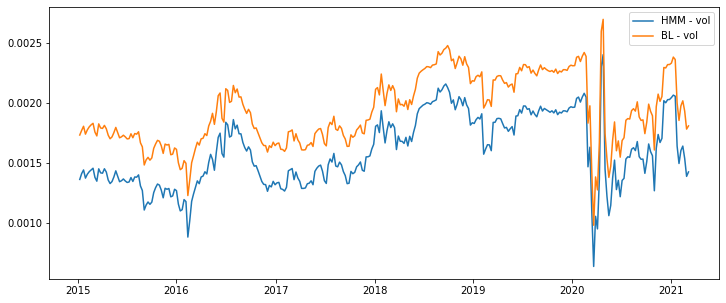

In [10]:
# Plotting predicted data
plot_name = "vol"

df_plot_ret = pd.DataFrame(prior_ret[plot_name].copy())
df_plot_ret = pd.concat([df_plot_ret,posterior_ret[plot_name], df_pct_ret[plot_name]],axis =1).dropna()
df_plot_ret.columns.values[0] ='HMM - {}'.format(plot_name)
df_plot_ret.columns.values[1] ='BL - {}'.format(plot_name)
df_plot_ret.columns.values[2] ='Actual - {}'.format(plot_name)

plt.figure(figsize=(12,5))
plt.plot(df_plot_ret.iloc[:,0],label = df_plot_ret.columns[0])
plt.plot(df_plot_ret.iloc[:,1], label = df_plot_ret.columns[1])
# plt.plot(df_plot_ret.iloc[:,2], label = df_plot_ret.columns[2])
plt.legend()

### Plotting predicted values from HMM and BL model against actual data

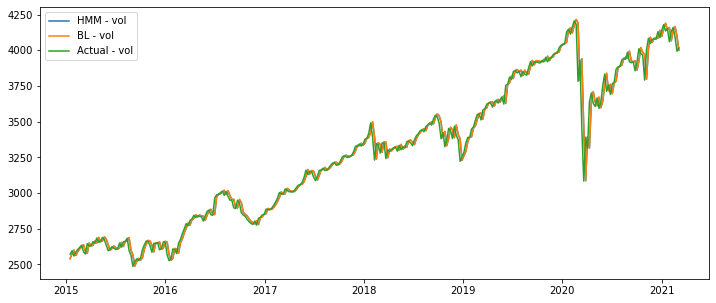

In [11]:
# Plotting predicted data
plot_name = "vol"

df_plot_val = pd.DataFrame(HMM_pred_val[plot_name].copy())
df_plot_val = pd.concat([df_plot_val,BL_pred_val[plot_name], df_price[plot_name]],axis =1).dropna()
df_plot_val.columns.values[0] ='HMM - {}'.format(plot_name)
df_plot_val.columns.values[1] ='BL - {}'.format(plot_name)
df_plot_val.columns.values[2] ='Actual - {}'.format(plot_name)

plt.figure(figsize=(12,5))
plt.plot(df_plot_val.iloc[:,0],label = df_plot_val.columns[0])
plt.plot(df_plot_val.iloc[:,1], label = df_plot_val.columns[1])
plt.plot(df_plot_val.iloc[:,2], label = df_plot_val.columns[2])
plt.legend()

### Generating BL asset allocation dataframe

In [12]:
BL_aa = pd.DataFrame(index=posterior_ret.dropna().index, columns = df_price.columns)
P = len(df_pct_ret)-len(posterior_ret)

for Q in range(0,len(posterior_ret)):
    mu = posterior_ret.iloc[Q]*52
    S = risk_models.CovarianceShrinkage(df_pct_ret.iloc[(P+Q+1-TCov):(P+Q+1)],returns_data=True,frequency=52).ledoit_wolf()
    ef = efficient_frontier.EfficientFrontier(mu,S)
    ef.max_sharpe()
    weights = ef.clean_weights()
    df_weights = pd.DataFrame(weights, index=[0])
    BL_aa.iloc[Q] = df_weights
    

### Plotting BL asset allocation

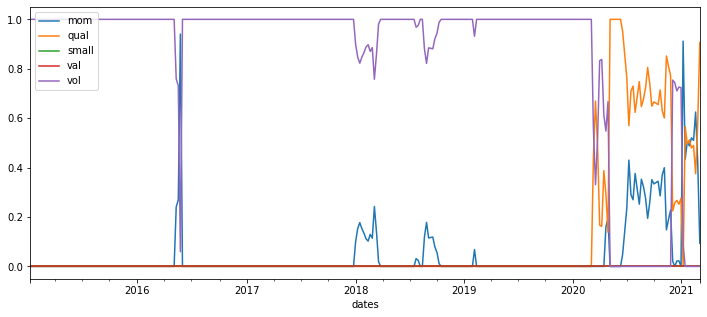

In [13]:
BL_aa.plot(figsize=(12,5))
plt.legend(loc='upper left')

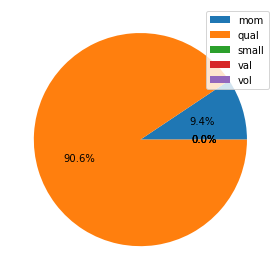

In [14]:
# Plot a pie chart of suggested weights from last BL asset allocation
labels = BL_aa.columns
plt.pie(BL_aa.iloc[-1],autopct='%.1f%%')
plt.tight_layout()
plt.legend(labels, loc="upper right")
plt.show()

### Plotting portfolio returns from BL asset allocation vs benchmark (does not include transaction costs)

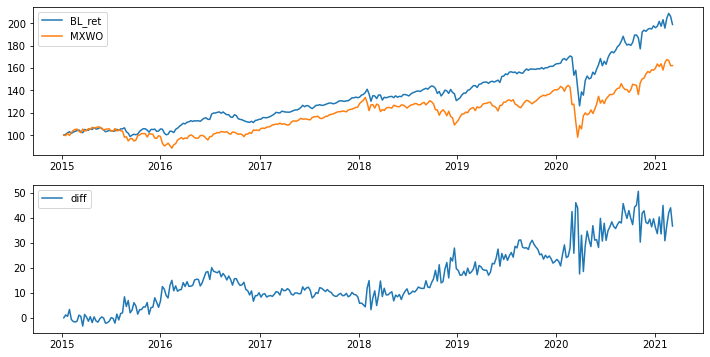

In [15]:
df_comp1t = pd.DataFrame(index=BL_aa.shift(1).dropna().index, columns = ["BL_ret"])
df_comp1 = pd.DataFrame(index=BL_aa.dropna().index, columns = ["BL_ret"])
BL_df_pct_ret = df_pct_ret.iloc[-len(df_comp1):]

for Q in range(0,len(df_comp1t)):
    ret = np.dot(BL_aa.iloc[Q+1].T,BL_df_pct_ret.iloc[Q])
    df_comp1t.iloc[Q] = ret

df_comp1.iloc[0]=100
for Q in range(0,len(df_comp1t)):
    ret = df_comp1.iloc[Q]*(1+df_comp1t.iloc[Q])
    df_comp1.iloc[Q+1] = ret
    
df_comp1 = pd.concat((df_comp1,df_benchmark),axis=1).dropna()
df_comp1 = df_comp1.div(df_comp1.iloc[0]) *100
df_comp1["diff"] = df_comp1.iloc[:,0] - df_comp1.iloc[:,1]

plt.figure(figsize=(12,6))

plt.subplot(211)
plt.plot(df_comp1.iloc[:,0], label=df_comp1.columns[0])
plt.plot(df_comp1.iloc[:,1], label=df_comp1.columns[1])
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(df_comp1.iloc[:,2], label=df_comp1.columns[2])
# # results[0].v.plot(figsize=(12,6),label="Convex Optimized")
# # results[1].v.plot(figsize=(12,6),label ="EW Buy and Hold")

plt.legend(loc='upper left')

### Generating convex optimized portfolio - long-only portfolio

In [16]:
# Setting up returns estimates for convex optimizer
r_hat = posterior_ret.copy()
r_hat["cash"] = 0.0
r_hat = r_hat.dropna()

# Creating a new returns dataframe with a cash column
returns = df_pct_ret.copy()
returns['cash'] = rf/52

# Setting up covariance estimates for convex optimizer - the reason we're not using cov_matrix is because we need a cash vector for the optimizer
P = len(returns.columns)

Sigma_hat = returns.rolling(window=TCov, min_periods=TCov, closed='neither').cov().dropna()
Sigma_hat = Sigma_hat.iloc[-P*K:,:]

# Using Ledoit wolf covariance shrinkage matrix
Z = len(df_pct_ret)-len(posterior_ret)
Ledoit_Sigma = risk_models.CovarianceShrinkage(df_pct_ret.iloc[(Z-TCov):(Z+1)], returns_data=True, frequency=1).ledoit_wolf()
Ledoit_Sigma["cash"] = 0
Ledoit_Sigma["dates"] = posterior_ret.index[0]
Ledoit_Sigma.loc["cash"]=0

for Q in range(1,len(posterior_ret)):
    temp_df = risk_models.CovarianceShrinkage(df_pct_ret.iloc[(Z+Q-TCov):(Z+Q+1)], returns_data=True, frequency=1).ledoit_wolf()
    temp_df["cash"]=0
    temp_df.loc["cash"]=0
    temp_df["dates"] = posterior_ret.index[Q]
    Ledoit_Sigma = pd.concat((Ledoit_Sigma,temp_df))
    
Ledoit_hat = pd.DataFrame(index=Sigma_hat.index, columns = Sigma_hat.columns)
Ledoit_temp_hat = Ledoit_Sigma.set_index("dates")

for Q in range(0,len(Sigma_hat)):
    Ledoit_hat.iloc[Q:Q+1,:] = Ledoit_temp_hat.iloc[Q:Q+1,:]

risk_model = cp.FullSigma(Ledoit_hat.reset_index(level=1, drop=True))

# Setting up cost models for the convex optimizer
transaction_cost = t_cost*10E-5
tcost_model=cp.TcostModel(half_spread= transaction_cost)

# Setting up a Single Period Optimizer with long only and long cash constraints
spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model],
                                constraints=[cp.LongCash(), cp.LongOnly()])

# Starting portfolio assuming USD 100k invested equally to all factors with 0 cash holdings
starting_cash = 100000
starting_pos = starting_cash/len(prior_ret.columns)
init_portfolio = pd.Series(index=returns.columns, data=starting_pos)
init_portfolio.cash = 0

# Running the convex optimizer and printing summary results
# market_sim=cp.MarketSimulator(returns.dropna(), [tcost_model], cash_key='cash')
# results = market_sim.run_backtest(init_portfolio,
#                                start_time=r_hat.index[0].strftime('%Y-%m-%d'),  end_time=r_hat.index[-1].strftime('%Y-%m-%d'),  
#                                policy=[spo_policy])

market_sim=cp.MarketSimulator(returns.dropna(), [tcost_model], cash_key='cash')
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time=StartPred,  end_time=r_hat.index[-1].strftime('%Y-%m-%d'),  
                               policies=[spo_policy, cp.Hold()],
                               parallel=False)
results[0].summary()

Number of periods                               322
Initial timestamp               2015-01-09 00:00:00
Final timestamp                 2021-03-05 00:00:00
Portfolio return (%)                         57.185
Excess return (%)                            52.339
Excess risk (%)                                34.0
Sharpe ratio                                  1.542
Max. drawdown                                27.953
Turnover (%)                                 59.656
Average policy time (sec)                     0.025
Average simulator time (sec)                  0.002


### Comparing performance vs Equal-Weighted Buy and Hold strategy vs Benchmark

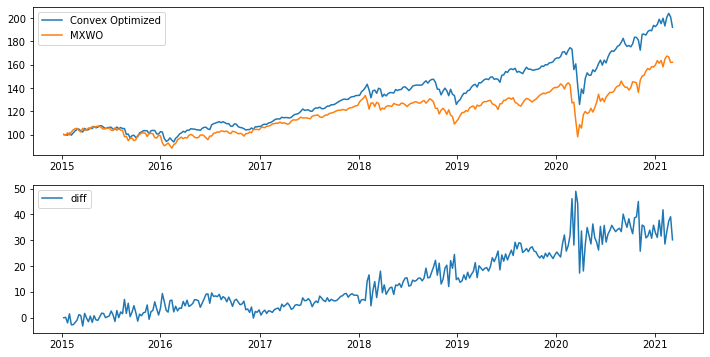

In [17]:
df_comp2 = pd.DataFrame(results[0].v, columns=["Convex Optimized"])
df_EW = pd.DataFrame(results[1].v, columns=["EW Buy and Hold"])
df_comp2 = pd.concat((df_comp2,df_benchmark,df_EW),axis=1).dropna()
df_comp2 = df_comp2.div(df_comp2.iloc[0]) *100
df_comp2["diff"] = df_comp2.iloc[:,0] - df_comp2.iloc[:,1]

plt.figure(figsize=(12,6))

plt.subplot(211)
plt.plot(df_comp2.iloc[:,0], label=df_comp2.columns[0])
plt.plot(df_comp2.iloc[:,1], label=df_comp2.columns[1])
# plt.plot(df_comp2.iloc[:,2], label=df_comp2.columns[2])
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(df_comp2.iloc[:,3], label=df_comp2.columns[3])
plt.legend(loc='upper left')

### Plotting Convex Optimized portfolio's asset allocation

<AxesSubplot:>

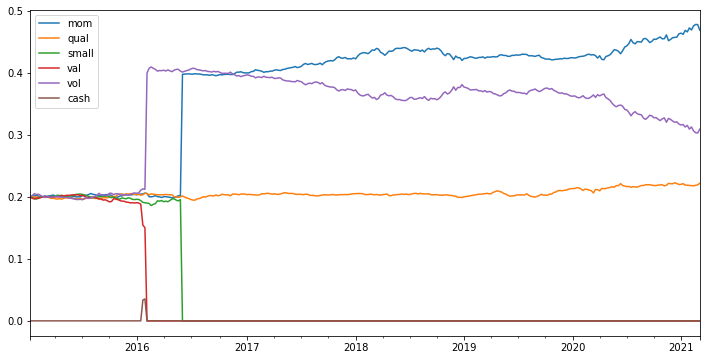

In [18]:
# Plotting weights of optimized portfolio
results[0].w.plot(figsize=(12,6))

### Plotting recommended asset allocation from convex optimized portfolio

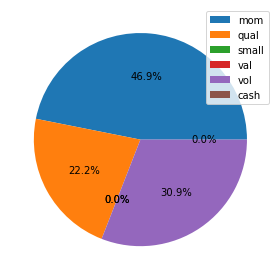

In [19]:
# Plot a pie chart of suggested weights from optimized results
weights = pd.DataFrame((results[0].w*100))
labels = weights.iloc[-1].index
plt.pie(weights.iloc[-1],autopct='%.1f%%')
plt.tight_layout()
plt.legend(labels, loc="upper right")
plt.show()

In [26]:
results[0].log_simulation()

TypeError: log_simulation() missing 5 required positional arguments: 't', 'u', 'h_next', 'risk_free_return', and 'exec_time'